# Make Correlation Map in Xarray

In [66]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
#import time
print('hoi')

hoi


### Input variables

In [91]:
#-----------------------------------------------------------------------------Winds with Temp
#Variables for the map
var='EXFuwind' # for the map

time_integral_map=True
time_integral_series=False

#tsvar='amundsen_shelf_temp_btw_200_700m' #to correlate it with
tsvar='dotson_to_cosgrove_massloss'

filename='Integral'


#Extra variables needed
tmvar='amundsen_shelf_break_uwind_avg' #corresponding mean time series (for finding the optimal correlation quickly)
vvar='EXFvwind' # for the vectors
#title='Correlation map of local zonal surface winds with Amundsen Shelf Temperatures'
#title='Correlation map of cumulative sum of local zonal surface winds with Amundsen Shelf Temperatures'
title='Correlation map of cumulative sum of local zonal surface winds with Dotson to Cosgrove Massloss'

#-----------------------------------------------------------------------------Temp with winds
#Variables for the map
#var='THETA' # for the map
#tsvar='amundsen_shelf_break_uwind_avg' #to correlate it with

#Extra variables needed
#tmvar='amundsen_shelf_temp_btw_200_700m' #corresponding mean time series (for finding the optimal correlation quickly)
#title='Correlation map of local Amundsen Shelf Temperatures with  PITT Zonal Shelf Break Winds'
#-----------------------------------------------------------------------------

#EXTRA OPTIONS----------------------------------------------------------------
members='all' #[0,1] #'all'
show_vectors=False #Do we want to show velocity vectors?
show_p=False #Do we want to show p values?
show_box=True #Do we want to show the PITT box?

method='mean' #'quadratic' #'mean' #'linear'

### Initialisation

In [68]:
#Where is everything located:
bd='/data/oceans_output/shelf/kaight/mitgcm'
gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
tf='timeseries_final.nc'

#Detrending method
long=25*12 #[months]
min_periods=5*12 #[months]

#What period are we interested in?
start='1920'
end='2013'

#Map parameters
region='amundsen_sea'
ymax = None#-70
window=24 #Smoothing period
final_lag=-10 #Lag we are interested in


### Read the data

In [69]:
#Reading the Data
if members=='all':
    pd=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)]
else:
    pd=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)][members[0]:members[-1]]
files=[os.path.join('output', f, 'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if (f[0]==str(1)) | (f[0]==str(2))]


data=None

for i, p in enumerate(pd):
    print(p)
    fd=[os.path.join(p, f) for f in files]
    fd.sort()
    #t0 = time.time()
    b=xr.open_dataset(fd[0])
    b=b[[var]]
    if var=='THETA':
        b=b.sel(Z=slice(-200, -700)).mean(dim='Z')

    for f in fd[1:]:
        #print(f)
        a=xr.open_dataset(f)
        a=a[[var]]
        if var=='THETA':
            a=a.sel(Z=slice(-200, -700)).mean(dim='Z')
        b=xr.concat([b,a], dim='time')
        
    #t1 = time.time()
    #total = t1-t0
    #print('Time for reading dataset:' + str(total))
    
    if i==0:
        data=b
    else:
        #t0 = time.time()
        data=xr.concat([data,b], dim='ens')
        #t1 = time.time()
        #total = t1-t0
        #print('Time for reading concatenating:' + str(total))
    
if show_vectors==True:
    vx=data.mean(dim='time')
    try:
        vx=vx.mean(dim='ens')
    except:
        print('No dimension Ens')

/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE02
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE03
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE04
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE05
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE06
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE07
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE08
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE09
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE10
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE11
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE12
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE13
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE14
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE15
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE16
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE17
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE18
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE19
/data/oceans_output/shelf/kaigh

In [70]:
#DETRENDING THE DATA
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    #return p
    x=da[dim]
    fit = xr.polyval(x, p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended


data=data.rolling(time=window, center=True).mean()
if method=='linear':
    deg=1
    data=detrend(data[var].sel(time=slice(start, end)), dims=['time'], deg=deg)
elif method=='quadratic':
    deg=2
    data=detrend(data[var].sel(time=slice(start, end)), dims=['time'], deg=deg)
elif method=='mean':
    long_mean=data.rolling(time=long, center=True, min_periods=min_periods).mean()
    data=data-long_mean
    data=data[var].sel(time=slice(start, end))
    
if time_integral_map==True:
    data=data.cumsum(dim='time')

In [81]:
#READ THE TIMESERIES OF INTEREST
tsfiles=[os.path.join(p, 'output', tf) for p in pd]

ts=None

print(p)
#fd=[os.path.join(p, f) for f in tsfiles]
fd=tsfiles
fd.sort()
#t0 = time.time()
b=xr.open_dataset(fd[0])
b=b[[tsvar]]

#t1 = time.time()
#total = t1-t0
#print('Time for reading dataset:' + str(total))

for i, f in enumerate(fd[1:]):
    #t0 = time.time()
    a=xr.open_dataset(f)
    a=a[[tsvar]]
    b=xr.concat([b,a], dim='ens')
    
    #t1 = time.time()
    #total = t1-t0
    #print('Time for reading dataset:' + str(total))

ts=b

#t0 = time.time()
#ts=ts.rolling(time=window, center=True).mean()
#ts=detrend(ts[tsvar].sel(time=slice(start, end)), dims=['time'], deg=degree)

ts=ts.rolling(time=window, center=True).mean()
if method=='linear':
    deg=1
    ts=detrend(ts[tsvar].sel(time=slice(start, end)), dims=['time'], deg=deg)
elif method=='quadratic':
    deg=2
    ts=detrend(ts[tsvar].sel(time=slice(start, end)), dims=['time'], deg=deg)
elif method=='mean':
    long_mean=ts.rolling(time=long, center=True, min_periods=min_periods).mean()
    ts=ts-long_mean
    ts=ts[tsvar].sel(time=slice(start, end))

#t1 = time.time()
#total = t1-t0
#print('Time for detrending:' + str(total))
    
    
if time_integral_series==True:
    ts=ts.cumsum(dim='time')

[[           nan            nan            nan ...            nan
             nan            nan]
 [           nan            nan            nan ...            nan
             nan            nan]
 [           nan            nan            nan ...            nan
             nan            nan]
 ...
 [3.64744285e-28 8.16731416e-28 1.45133317e-27 ... 2.72818453e-05
  3.58250910e-05 5.07679383e-05]
 [7.48861072e-27 8.17803427e-27 7.77638576e-27 ... 9.11104070e-05
  1.15636316e-04 1.51560429e-04]
 [1.40217660e-25 9.39914209e-26 6.43185643e-26 ... 3.14952284e-04
  3.66150896e-04 4.24879225e-04]]


In [72]:
#Reading corresponding time series for finding optimal lag.
tm=None

#fd=[os.path.join(p, f) for f in tsfiles]
fd.sort()
#t0 = time.time()
b=xr.open_dataset(fd[0])
b=b[[tmvar]]

#t1 = time.time()
#total = t1-t0
#print('Time for reading dataset:' + str(total))

for i, f in enumerate(fd[1:]):
    #t0 = time.time()
    a=xr.open_dataset(f)
    a=a[[tmvar]]
    b=xr.concat([b,a], dim='ens')
    
tm=b

#tm=tm.rolling(time=window, center=True).mean()
#tm=detrend(tm[tmvar].sel(time=slice(start, end)), dims=['time'], deg=degree)

tm=tm.rolling(time=window, center=True).mean()
if method=='linear':
    deg=1
    tm=detrend(tm[tmvar].sel(time=slice(start, end)), dims=['time'], deg=deg)
elif method=='quadratic':
    deg=2
    tm=detrend(tm[tmvar].sel(time=slice(start, end)), dims=['time'], deg=deg)
elif method=='mean':
    long_mean=tm.rolling(time=long, center=True, min_periods=min_periods).mean()
    tm=tm-long_mean
    tm=tm[tmvar].sel(time=slice(start, end))

    
if time_integral_map==True:
    tm=tm.cumsum(dim='time')

<xarray.DataArray 'dotson_to_cosgrove_massloss' (ens: 20, time: 1128)>
array([[ -0.5187496 ,   0.04642941,   0.54227091, ...,          nan,
                 nan,          nan],
       [ 13.11666222,  13.8929179 ,  14.72710693, ...,          nan,
                 nan,          nan],
       [-23.93952532, -23.77740335, -23.4220465 , ...,          nan,
                 nan,          nan],
       ...,
       [ 28.32710661,  29.77515467,  31.13175815, ...,          nan,
                 nan,          nan],
       [ 12.0604329 ,  10.23993315,   8.35822566, ...,          nan,
                 nan,          nan],
       [ -3.53869786,  -4.02864425,  -4.25306973, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2013-12-01 00:00:00
Dimensions without coordinates: ens

### Finding the optimal Lag and Performing Correlation

<xarray.DataArray 'ens' (ens: 20)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])
Dimensions without coordinates: ens


3

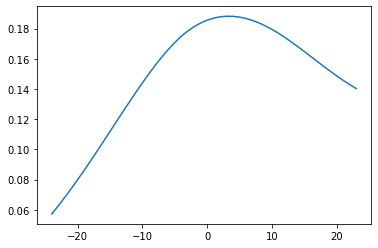

In [83]:
#Finding optimal lag
try:
    print(ts['ens'])
except:
    print('Create Ens')
    data=data.expand_dims("ens")
    ts=ts.expand_dims("ens")
    tm=tm.expand_dims("ens")
    
lags=np.arange(-24, 24)
r=np.zeros(len(lags))

for z, lag in enumerate(lags):
    ts_temp=ts.shift(time=lag)
    tma=tm.stack(ens_time=['ens', 'time'])
    tsa=ts_temp.stack(ens_time=['ens', 'time'])
    a=xr.corr(tma, tsa, dim='ens_time')
    r[z]=a

plt.plot(lags, r)
maxind=np.argmax(r)
final_lag=lags[maxind]
final_lag

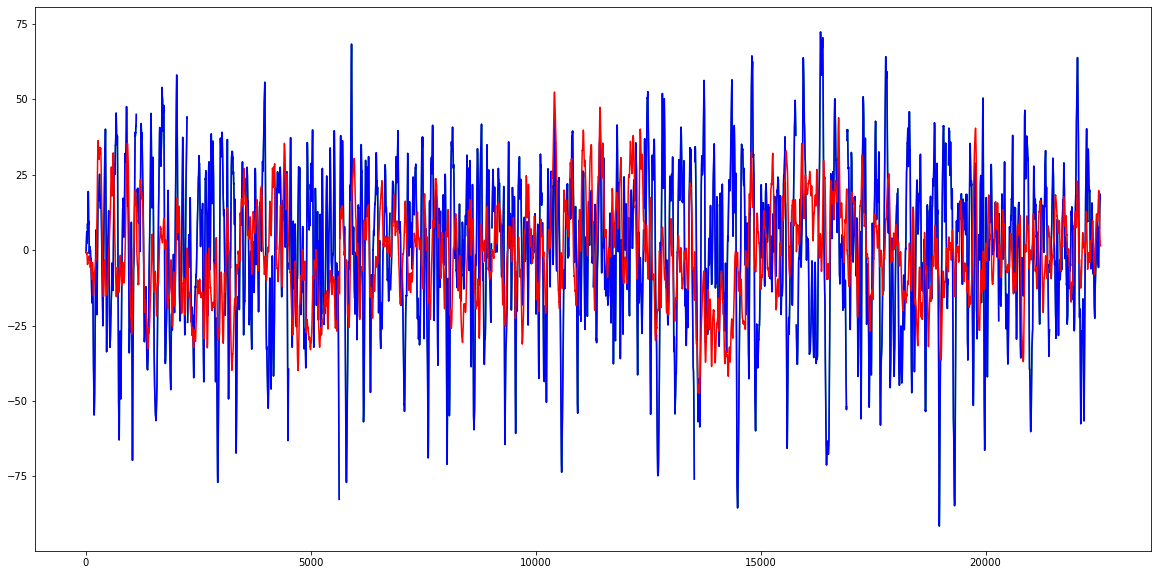

In [84]:
#Check if optimal lag makes sense!
ts_temp=ts.shift(time=final_lag)
tma=tm.stack(ens_time=['ens', 'time'])
tsa=ts_temp.stack(ens_time=['ens', 'time'])
ts_temp=ts.shift(time=0)
tsb=ts_temp.stack(ens_time=['ens', 'time'])

plt.figure(figsize=(20,10))
plt.plot(tsa, c='g')
plt.plot(tsb, c='b')
plt.plot(tma, c='r')


In [85]:
#Correlation
ts_temp=ts.shift(time=final_lag)
da=data.stack(ens_time=['ens', 'time'])
tsa=ts_temp.stack(ens_time=['ens', 'time'])

#This is a bit tricky.... Drop the NaN values...
da=da.drop_sel(ens_time=tsa[np.isnan(tsa)].ens_time)
tsa=tsa.dropna(dim='ens_time')

In [86]:
cors=np.zeros((len(da.YC), len(da.XC)))
p=np.zeros((len(da.YC), len(da.XC)))
    
for i in range(len(da.YC)):
    for j in range(len(da.XC)):
        #try:
        cors[i,j], p[i,j]=stats.pearsonr(da.values[i,j,:],tsa)
        #except:
            #cors[i,j]=np.nan
            #p[i,j]=np.nan
print('Finished!')

/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Finished!


### Visualisation

In [87]:
#From my code to Kaitlin's code
from mitgcm_python_master.plot_latlon import latlon_plot
from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors
from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels

grid = Grid(gp)
mask = grid.get_region_mask(region)
mask=mask.astype(bool)

In [92]:
#Prepare everything for the map!
r_data = np.zeros([grid.ny, grid.nx])
#if show_p==True:
r_data[mask] = cors[mask]
#else:
    #r_data[mask] = mean_r.values[mask]
r_data = mask_land_ice(r_data, grid)
print(('Mean r over all points and ensemble members = '+str(np.nanmean(r_data))))
r_data[np.isnan(r_data)]=0

vmin=np.min(r_data[mask])
vmax=np.max(r_data[mask])      

levels=np.arange(0, 1, 0.1)

#Completing the title
title=title+'\n (both {} month moving average,'.format(str(window))
if method=='linear':
    title+=' linearly detrended)'
elif method=='quadratic':
    title+=' quadratically detrended)'
elif method=='mean':
    title+='  detrended with {} month rolling mean)'.format(str(long))

if members=='all':
    title+=' (full ensemble)'
else:
    title+=' ({} members)'.format(str(members[-1]-members[0]))


Mean r over all points and ensemble members = 0.10816828910776263


Saving ./correlation_map_dotson_to_cosgrove_massloss_EXFuwind_mean_3Integral.png


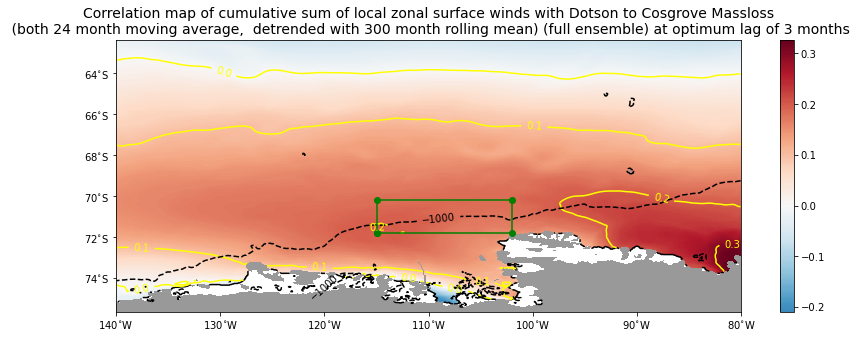

In [93]:
#Plot the Map
fig, ax=plt.subplots(figsize=(14,5))

latlon_plot(r_data, grid, ctype='plusminus', ymax=ymax, vmin=None, vmax=None, title=title+' at optimum lag of '+str(final_lag)+' months', titlesize=14, figsize=(14,5), ax=ax)
r=ax.contour(grid.lon_2d, grid.lat_2d, r_data, levels=levels, colors=['yellow'])
plt.clabel(r, levels)

bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
plt.clabel(bath, [-1000])

if show_p==True:
    p_data = np.zeros([grid.ny, grid.nx])
    p_data[mask] = p[mask]
    p_data = mask_land_ice(p_data, grid)
    a=5
    ax.scatter(grid.lon_2d[::a, ::a][(p_data[::a, ::a]<=0.05) & (p_data[::a, ::a].mask==False)], grid.lat_2d[::a, ::a][(p_data[::a, ::a]<=0.05) & (p_data[::a, ::a].mask==False)], c='k', s=.02)
    
if show_box==True:
    x=[-115, -102, -102, -115, -115]
    y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
    ax.plot(x, y, c='g', marker='o')
   

finished_plot(fig, fig_name='./'+'correlation_map_'+tsvar+'_'+var+'_'+method+'_'+str(final_lag)+filename+'.png', dpi=300)

In [12]:
#COMPUTING V VECTORS
if show_vectors==True:
    datay=None

    for i, p in enumerate(pd):
        print(p)
        fd=[os.path.join(p, f) for f in files]
        fd.sort()
        #t0 = time.time()
        b=xr.open_dataset(fd[0])
        b=b[[vvar]]

        for f in fd[1:]:
            a=xr.open_dataset(f)
            a=a[[vvar]]
            b=xr.concat([b,a], dim='time')

        #t1 = time.time()
        #total = t1-t0
        #print('Time for reading dataset:' + str(total))

        if i==0:
            datay=b
        else:
            #t0 = time.time()
            datay=xr.concat([datay,b], dim='ens')
            #t1 = time.time()
            #total = t1-t0
            #print('Time for reading concatenating:' + str(total))

    vy=datay.mean(dim='time')
    vy=vy.mean(dim='ens')
    


/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE02
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE03
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE04
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE05
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE06
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE07
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE08
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE09
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE10
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE11
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE12
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE13
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE14
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE15
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE16
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE17
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE18
/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE19
/data/oceans_output/shelf/kaigh

/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Saving ./correlation_map_dotson_to_cosgrove_massloss_EXFuwind_vectors.png


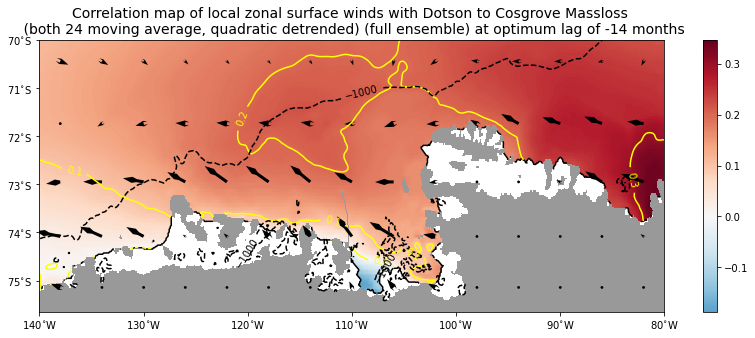

In [13]:
if show_vectors==True:
    fig, ax=plt.subplots(figsize=(14,5))
    latlon_plot(r_data, grid, ctype='plusminus', ymax=ymax, vmin=None, vmax=None, title=title+' at optimum lag of '+str(final_lag)+' months', titlesize=14, figsize=(14,5), ax=ax)
    r=ax.contour(grid.lon_2d, grid.lat_2d, r_data, levels=levels, colors=['yellow'])
    plt.clabel(r, levels)
    bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
    plt.clabel(bath, [-1000])
    overlay_vectors(ax, vx.to_array().values[0,:,:], vy.to_array().values[0,:,:], grid, chunk_x=40, chunk_y=40, scale=1e2, headwidth=2, headlength=3)
    finished_plot(fig, fig_name='./'+'correlation_map_'+tsvar+'_'+var+'_vectors.png', dpi=300)

/tmp/ipykernel_13910/366513485.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time=data.indexes['time'].to_datetimeindex()


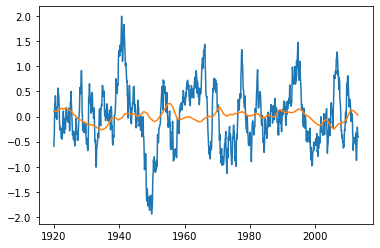

In [12]:
#Check if timeseries are indeed detrended in a seemingly logical manner.
time=data.indexes['time'].to_datetimeindex()
plt.plot(time, data[0, :, 150, 150])
plt.plot(time, ts[0,:])

In [6]:
#Reading the Data
pd=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)][0:1]
files=[os.path.join('output', f, 'MITgcm/output.nc') for f in os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output') if (f[0]==str(1)) | (f[0]==str(2))][0:1]

data=None

for i, p in enumerate(pd):
    print(p)
    fd=[os.path.join(p, f) for f in files]
    fd.sort()
    #t0 = time.time()
    b=xr.open_dataset(fd[0])

/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01


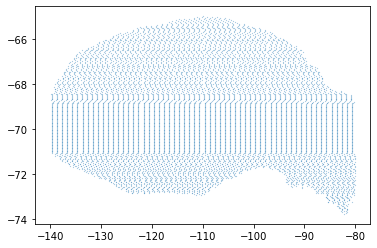

In [25]:
plt.scatter(grid.lon_2d[p_data==0][::10],grid.lat_2d[p_data==0][::10], s=0.02)

In [30]:
p_data[-1,:].mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [111]:
from sys import getsizeof
getsizeof(data.values)/1e9

20.791296152

In [106]:
data

<xarray.DataArray 'EXFuwind' (ens: 20, time: 1128, YC: 384, XC: 600)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 7.03507423e-01,  7.00684071e-01,  6.98454857e-01, ...,
          -1.08637810e-01, -1.09912872e-01, -1.13177776e-01],
         [ 7.08329678e-01,  7.04356670e-01,  7.00178623e-01, ...,
          -1.04647636e-01, -1.06856346e-01, -1.10035419e-01],
         [ 7.13158131e-01,  7.11898804e-01,  7.10570335e-01, ...,
          -9.99779701e-02, -1.03374481e-01, -1.06799603e-01]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
          -6.63999844e+00, -6.85486126e+00, -7.01367807e+00],
         [ 2.55231190e+00,  2.54166746e+00,  2.55565357e+00, ...,
          -6.78742504e+00, -6.95757341e+00, -7.09288025e+00],
         [ 2.53020382e+00,  2.53394318e+00,  2.53245449e+00, ...,
          -7.07787371e+00, -7.11318684e+00, -7.15455961e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 2.53905058e+00,  2.55375433e+00,  2.56609249e+00, ...,
          -6.63999844e+00, -6.85486126e+00, -7.01367807e+00],
         [ 2.55231190e+00,  2.54166746e+00,  2.55565357e+00, ...,
          -6.78742504e+00, -6.95757341e+00, -7.09288025e+00],
         [ 2.53020382e+00,  2.53394318e+00,  2.53245449e+00, ...,
          -7.07787371e+00, -7.11318684e+00, -7.15455961e+00]]]],
      dtype=float32)
Coordinates:
    iter     (time) int64 1576800 1581264 1585296 ... 6504192 6508656 6512976
  * time     (time) object 1920-01-01 00:00:00 ... 2013-12-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
Dimensions without coordinates: ens

In [112]:
np.shape(data.values)

(20, 1128, 384, 600)